# Waveform Analysis Exploration 

Need a function for mass data addition (all the unique EDF files). I'll merge them into a single table for easy analysis. Waves are waves-- so long as they have the same filtering and they're all originally raw EEG! 

In [1]:
import numpy as np
import pandas as pd
import mne 
from mne.time_frequency import psd_array_welch
import matplotlib.pyplot as plt

def process_edf_pair(psg_path, hypnogram_path): 
    '''
    Loads EDF EEG recording and corresponding hypnogram 
    Extracts 30s epochs, labels them, and returns a features df

    Returns: 
        features (pd.DataFrame): Features + newly created 'label' col (sleep stage as str)
    '''

    raw = mne.io.read_raw_edf(psg_path, preload=True) 
    raw.set_annotations(mne.read_annotations(hypnogram_path))
    raw.pick(['EEG Fpz-Cz']) 

    events, event_id = mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events=events, event_id=event_id,
                        tmin=0, tmax=30, baseline=None, preload=True)
    
    # Label mapping (using standardidized strings)
    reverse_event_map = {v: k for k, v in event_id.items()} 

    stage_map = {
        'Sleep stage W': 'Wake',
        'Sleep stage 1': 'N1',
        'Sleep stage 2': 'N2',
        'Sleep stage 3': 'N3',
        'Sleep stage 4': 'N3',
        'Sleep stage R': 'REM'
    }

    labels = []
    for e in epochs.events:
        label = stage_map.get(reverse_event_map.get(e[-1]), None) 
        labels.append(label if label is not None else 'UNKNOWN')

    # Filtering unknowns
    valid_mask = [label != 'UNKNOWN' for label in labels]
    epochs = epochs[valid_mask]
    labels = [l for l in labels if l != 'UNKNOWN']

    # Feat Extraction
    data = epochs.get_data()
    sfreq = epochs.info['sfreq'] 
    psds, freqs = psd_array_welch(data, sfreq=sfreq, fmin=0.5, fmax=40, n_fft=256)

    features = pd.DataFrame({
        'delta': bandpower(psds, freqs, (0.5, 4)),
        'theta': bandpower(psds, freqs, (4, 8)),
        'alpha': bandpower(psds, freqs, (8, 13)),
        'beta':  bandpower(psds, freqs, (13, 30)),
        'label': labels
    })

    return features

def bandpower(psds, freqs, band):
    '''
    Small hepler for process_edf_pair
    Returns mean band power in specified frequency range
    '''
    idx = (freqs >= band[0]) & (freqs <= band[1])
    return psds[:, :, idx].mean(axis=-1).mean(axis=1)



### Now Loop over all .edf files!

In [2]:
import os

# Match PSG and Hypnogram files by prefix
data_dir = '../data/sleep_waves/'
files = os.listdir(data_dir) 

# Grouping PSG and Hypnogram files by shared sybject root (first 7 chars) 
psg_files = [f for f in files if f.endswith('-PSG.edf')]
hyp_files = [f for f in files if 'Hypnogram' in f] 

file_pairs = []

for psg in psg_files:
    subj_root = psg[:7] # example: 'ST7011J'
    matching_hyp = [h for h in hyp_files if h.startswith(subj_root)]

    if matching_hyp: 
        psg_path = os.path.join(data_dir, psg) 
        hyp_path = os.path.join(data_dir, matching_hyp[0]) # Note: assuming only 1 match! 
        file_pairs.append((psg_path, hyp_path)) 
    else: 
        print(f'No matching hypnogram for {psg}')

print(f'Found {len(file_pairs)} valid PSG-Hypnogram edf pairs') 

# Process all and concat 
all_feats = []

for psg, hyp in file_pairs:
    print(f"🧪 Processing: {os.path.basename(psg)} & {os.path.basename(hyp)}")
    try: 
        features = process_edf_pair(psg, hyp)
        all_feats.append(features) 
        print(f'\n✅ Processed: {os.path.basename(psg)}:{len(features)} epochs\n')
    except Exception as e: 
        print(f'❌ Failed on {psg}: {e}')

df_edf = pd.concat(all_feats, ignore_index=True) 




Found 44 valid PSG-Hypnogram edf pairs
🧪 Processing: ST7011J0-PSG.edf & ST7011JP-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7011J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3589999  =      0.000 ... 35899.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
231 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 231 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7011J0-PSG.edf:231 epochs

🧪 Processing: ST7012J0-PSG.edf & ST7012JP-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7012J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3131999  =      0.000 ... 31319.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
173 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 173 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7012J0-PSG.edf:173 epochs

🧪 Processing: ST7021J0-PSG.edf & ST7021JM-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7021J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3059999  =      0.000 ... 30599.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
135 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 135 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7021J0-PSG.edf:135 epochs

🧪 Processing: ST7022J0-PSG.edf & ST7022JM-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7022J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3075999  =      0.000 ... 30759.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 148 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7022J0-PSG.edf:148 epochs

🧪 Processing: ST7041J0-PSG.edf & ST7041JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7041J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3115999  =      0.000 ... 31159.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
142 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 142 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7041J0-PSG.edf:141 epochs

🧪 Processing: ST7042J0-PSG.edf & ST7042JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7042J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3470999  =      0.000 ... 34709.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7042J0-PSG.edf:137 epochs

🧪 Processing: ST7051J0-PSG.edf & ST7051JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7051J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3219999  =      0.000 ... 32199.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
184 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 184 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7051J0-PSG.edf:184 epochs

🧪 Processing: ST7052J0-PSG.edf & ST7052JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7052J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3282999  =      0.000 ... 32829.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 116 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7052J0-PSG.edf:116 epochs

🧪 Processing: ST7061J0-PSG.edf & ST7061JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7061J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3256999  =      0.000 ... 32569.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 83 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7061J0-PSG.edf:83 epochs

🧪 Processing: ST7062J0-PSG.edf & ST7062JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7062J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3277999  =      0.000 ... 32779.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
92 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 92 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7062J0-PSG.edf:92 epochs

🧪 Processing: ST7071J0-PSG.edf & ST7071JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7071J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2745999  =      0.000 ... 27459.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 139 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7071J0-PSG.edf:139 epochs

🧪 Processing: ST7072J0-PSG.edf & ST7072JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7072J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2745999  =      0.000 ... 27459.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
161 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 161 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7072J0-PSG.edf:161 epochs

🧪 Processing: ST7081J0-PSG.edf & ST7081JW-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7081J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2899999  =      0.000 ... 28999.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations(hypnogram_path))
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 160 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7081J0-PSG.edf:160 epochs

🧪 Processing: ST7082J0-PSG.edf & ST7082JW-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7082J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2852999  =      0.000 ... 28529.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations(hypnogram_path))
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 129 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7082J0-PSG.edf:129 epochs

🧪 Processing: ST7091J0-PSG.edf & ST7091JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7091J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2985999  =      0.000 ... 29859.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
134 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 134 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7091J0-PSG.edf:134 epochs

🧪 Processing: ST7092J0-PSG.edf & ST7092JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7092J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2886999  =      0.000 ... 28869.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
190 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 190 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7092J0-PSG.edf:190 epochs

🧪 Processing: ST7101J0-PSG.edf & ST7101JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7101J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3295999  =      0.000 ... 32959.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
161 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 161 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7101J0-PSG.edf:155 epochs

🧪 Processing: ST7102J0-PSG.edf & ST7102JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7102J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2981999  =      0.000 ... 29819.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 101 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7102J0-PSG.edf:96 epochs

🧪 Processing: ST7111J0-PSG.edf & ST7111JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7111J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3139999  =      0.000 ... 31399.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 83 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7111J0-PSG.edf:77 epochs

🧪 Processing: ST7112J0-PSG.edf & ST7112JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7112J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3066999  =      0.000 ... 30669.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 113 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7112J0-PSG.edf:105 epochs

🧪 Processing: ST7121J0-PSG.edf & ST7121JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7121J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3119999  =      0.000 ... 31199.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
172 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 172 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7121J0-PSG.edf:163 epochs

🧪 Processing: ST7122J0-PSG.edf & ST7122JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7122J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3034999  =      0.000 ... 30349.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7122J0-PSG.edf:82 epochs

🧪 Processing: ST7131J0-PSG.edf & ST7131JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7131J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2765999  =      0.000 ... 27659.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
89 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 89 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7131J0-PSG.edf:89 epochs

🧪 Processing: ST7132J0-PSG.edf & ST7132JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7132J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2697999  =      0.000 ... 26979.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 116 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7132J0-PSG.edf:116 epochs

🧪 Processing: ST7141J0-PSG.edf & ST7141JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7141J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2760999  =      0.000 ... 27609.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
127 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 127 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7141J0-PSG.edf:123 epochs

🧪 Processing: ST7142J0-PSG.edf & ST7142JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7142J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2750999  =      0.000 ... 27509.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 91 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7142J0-PSG.edf:82 epochs

🧪 Processing: ST7151J0-PSG.edf & ST7151JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7151J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3850999  =      0.000 ... 38509.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
178 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 178 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7151J0-PSG.edf:178 epochs

🧪 Processing: ST7152J0-PSG.edf & ST7152JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7152J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3224999  =      0.000 ... 32249.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
167 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 167 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7152J0-PSG.edf:167 epochs

🧪 Processing: ST7161J0-PSG.edf & ST7161JM-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7161J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3329999  =      0.000 ... 33299.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 148 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7161J0-PSG.edf:148 epochs

🧪 Processing: ST7162J0-PSG.edf & ST7162JM-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7162J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3003999  =      0.000 ... 30039.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 180 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7162J0-PSG.edf:180 epochs

🧪 Processing: ST7171J0-PSG.edf & ST7171JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7171J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2892999  =      0.000 ... 28929.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
194 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 194 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7171J0-PSG.edf:194 epochs

🧪 Processing: ST7172J0-PSG.edf & ST7172JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7172J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3019999  =      0.000 ... 30199.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations(hypnogram_path))
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 199 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7172J0-PSG.edf:199 epochs

🧪 Processing: ST7181J0-PSG.edf & ST7181JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7181J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3087999  =      0.000 ... 30879.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations(hypnogram_path))
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 101 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7181J0-PSG.edf:101 epochs

🧪 Processing: ST7182J0-PSG.edf & ST7182JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7182J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3393999  =      0.000 ... 33939.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
109 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 109 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7182J0-PSG.edf:109 epochs

🧪 Processing: ST7191J0-PSG.edf & ST7191JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7191J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3378999  =      0.000 ... 33789.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 148 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7191J0-PSG.edf:148 epochs

🧪 Processing: ST7192J0-PSG.edf & ST7192JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7192J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3289999  =      0.000 ... 32899.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 85 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7192J0-PSG.edf:85 epochs

🧪 Processing: ST7201J0-PSG.edf & ST7201JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7201J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2911999  =      0.000 ... 29119.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 137 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7201J0-PSG.edf:135 epochs

🧪 Processing: ST7202J0-PSG.edf & ST7202JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7202J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2999999  =      0.000 ... 29999.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations(hypnogram_path))
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
121 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 121 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7202J0-PSG.edf:120 epochs

🧪 Processing: ST7211J0-PSG.edf & ST7211JJ-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7211J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3236999  =      0.000 ... 32369.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
166 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 166 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7211J0-PSG.edf:166 epochs

🧪 Processing: ST7212J0-PSG.edf & ST7212JJ-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7212J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3161999  =      0.000 ... 31619.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
142 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 142 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7212J0-PSG.edf:142 epochs

🧪 Processing: ST7221J0-PSG.edf & ST7221JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7221J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3295999  =      0.000 ... 32959.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 138 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7221J0-PSG.edf:138 epochs

🧪 Processing: ST7222J0-PSG.edf & ST7222JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7222J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2873999  =      0.000 ... 28739.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
131 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 131 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7222J0-PSG.edf:131 epochs

🧪 Processing: ST7241J0-PSG.edf & ST7241JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7241J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3260999  =      0.000 ... 32609.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 102 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7241J0-PSG.edf:99 epochs

🧪 Processing: ST7242J0-PSG.edf & ST7242JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7242J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2947999  =      0.000 ... 29479.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_23592\1452323569.py:16: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
146 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 146 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)

✅ Processed: ST7242J0-PSG.edf:145 epochs



In [3]:
df_edf.to_csv('../data/eeg_hypno.csv', index=False)

df_edf

,delta,theta,alpha,beta,label
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake
1,6.851487e-12,2.188516e-12,1.104633e-12,8.372303e-13,N1
2,2.707088e-11,3.864857e-12,1.452854e-12,8.678398e-13,N2
3,2.403117e-11,1.126442e-12,1.835699e-12,5.003665e-13,N1
4,4.395439e-11,2.545034e-12,1.276473e-12,8.361875e-13,N2
...,...,...,...,...,...
6021,1.416674e-11,4.520787e-12,1.160433e-12,2.291765e-13,REM
6022,4.827426e-10,7.670029e-12,3.671621e-12,3.220177e-12,Wake
6023,5.953652e-12,1.894862e-12,1.252515e-12,5.406972e-13,N1
6024,1.037589e-11,2.498837e-12,8.997023e-13,2.299988e-13,N2


### Training a Basic Classifier (RF)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

X = df_edf.drop(columns=['label'])
y = df_edf['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)

clf = RandomForestClassifier(n_estimators=100, random_state=10, class_weight='balanced')
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test) 
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          N1       0.57      0.56      0.56       270
          N2       0.54      0.58      0.56       359
          N3       0.71      0.78      0.74       346
         REM       0.60      0.38      0.47        78
        Wake       0.62      0.50      0.55       153

    accuracy                           0.61      1206
   macro avg       0.61      0.56      0.58      1206
weighted avg       0.61      0.61      0.61      1206



### Pipeline Project Adapted to Waveforms:

In [10]:
import sys
import os

from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(".."))

from src.run_pipeline import tune_and_train_full

# Label Encoding with decoding built into tune_and_train_full()
le = LabelEncoder()
y_encoded = le.fit_transform(y) 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=10)

rf_wave, best_params = tune_and_train_full(RandomForestClassifier, 
                    'Random Forest', 
                    X_train, 
                    y_train,
                    X_test=X_test, 
                    y_test=y_test, 
                    model_params={'class_weight': 'balanced'},
                    sample_frac=0.95, 
                    scoring='accuracy',
                    label_encoder=le) 

🔍 Sampled 4293 rows (95.0%)
Class distribution:
1    1277
2    1232
0     961
4     543
3     280

Starting Grand Tuner | CV: 5 | Scoring: accuracy
Model: RandomForestClassifier | SMOTE: True | Random Iterations: 20

**RandomForestClassifier param grid is None, using default

Fitting 5 folds for each of 20 candidates, totalling 100 fits
⏱️ RandomizedSearchCV completed in 0.45 minutes

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\andre\OneDrive\Desktop\Code_Projects\.venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\andre\OneDrive\Deskto

⏱️ GridSearchCV completed in 0.36 minutes

🏆 Best Hyperparameters: {
  "classifier__n_estimators": 300,
  "classifier__min_samples_split": 2,
  "classifier__min_samples_leaf": 5,
  "classifier__max_features": "log2",
  "classifier__max_depth": 10
}

📊 Best accuracy: 0.5605
💾 Saved best params for RandomForestClassifier to ../tuned_params\RandomForestClassifier_best_params.json


[TRAINING] Starting model training...

→ Training Random Forest with params:
{
    "class_weight": "balanced",
    "classifier__n_estimators": 300,
    "classifier__min_samples_split": 2,
    "classifier__min_samples_leaf": 5,
    "classifier__max_features": "log2",
    "classifier__max_depth": 10
}

✅ Random Forest trained | Saved to ../models\Random Forest.pkl

 Running evaluation on test set...
⚠️ Imbalanced test set detected (Minority class = 6.50%)

Label decoder active:
  y_test unique: [0 1 2 3 4]
  Classes: ['N1' 'N2' 'N3' 'REM' 'Wake']

Evaluating Model: RandomForestClassifier
Hyperparameters:
{
    "b

## Great, Classifier is Built! What Now?
Just completed work on a sleep stage classifier that is ~60% effective. While that's not bad... we can do better, by using the elements of the data to our advantage: 
- Sleep is **not** random, it follows structured stage transitions
- HMM can capture those structured transitions as probabilities
- We can use a HMM approach to smooth the pipeline model's predictions into a more biologically probably sequence.


### While Discussing Goals: 
**Real-time sleep classification**. It's possible (with a ton of work). That is our final product. 

<hr>

### Back to Reality: HMM Smoothing Pass 

It's important to remember that the HMM is *not* making new predictions or replacing the already nicely trained and optimized classifier. The HMM will function to refine the outputs.  
  
We'll learn from the data in order to estimate stage transition probabilities. For example: how likely are you to stay in N2, or jump to N3, etc. 

In [11]:
# Step 1. 
# Convert predicted and true labels back to class indices

from sklearn.preprocessing import LabelEncoder

y_test_decoded = le.inverse_transform(y_test) 
y_pred_decoded = le.inverse_transform(rf_wave.predict(X_test)) 

# Re-encode with a fresh label encoder for HMM
le_hmm = LabelEncoder()
y_test_idx = le_hmm.fit_transform(y_test_decoded)
y_pred_idx = le_hmm.fit_transform(y_pred_decoded) 

In [12]:
# Step 2.
# Fit the HMM (only on stage transitions)

from hmmlearn import hmm
import numpy as np

n_states = len(le_hmm.classes_) 
model_hmm = hmm.GaussianHMM(n_components=5, covariance_type='full', n_iter=100)

# Now reshape to (n_samples, 1)-- required by hmmlearn
y_test_seq = y_test_idx.reshape(-1, 1) 

# Fit transition and start probs using the true label seq
model_hmm.fit(y_test_seq) 

# Define domain-informed transition matrix (Wake, N1, N2, N3, REM)
custom_transitions = np.array([
    [0.1,  0.8,  0.05, 0.0,  0.05],  # Wake -> mostly N1
    [0.0,  0.1,  0.8,  0.1,  0.0],  # N1 -> mostly N2
    [0.0,  0.1,  0.2,  0.6,  0.1],  # N2 -> transition to N3
    [0.0,  0.0,  0.4,  0.4,  0.2],  # N3 -> some REM or back to N2
    [0.2,  0.3,  0.3,  0.0,  0.2],  # REM -> looping back, or staying REM
])

# Normalize to ensure each row sums to 1
custom_transitions = custom_transitions / custom_transitions.sum(axis=1, keepdims=True)
custom_transitions

model_hmm.transmat_ = custom_transitions
model_hmm.startprob_ = np.array([0.6, 0.4, 0.0, 0.0, 0.0]) 

In [13]:
# Step 3. 
# Use Classifier preds + HMM for smoothing

# Classifier pred sequence (unsmoothed) 
y_pred_seq = y_pred_idx.reshape(-1, 1) 

# Applying Viterbi to get smoothed predictions
smoothed_idx = model_hmm.predict(y_pred_seq) 

# Decode to original class labels
smoothed_labels = le_hmm.inverse_transform(smoothed_idx) 

To make things more clear, we now have: 
- `y_test_decoded` -- ground truth
- `y_pred_decoded` -- raw classifier 
- `smoothed_labels` -- post-HMM output

In [14]:
# Step 4. 
# Evaluate Improvements

from sklearn.metrics import classification_report

print("🔍 Classifier (Raw) Performance:")
print(classification_report(y_test_decoded, y_pred_decoded))

print("🧠 HMM-Smooth Performance:")
print(classification_report(y_test_decoded, smoothed_labels))


🔍 Classifier (Raw) Performance:
              precision    recall  f1-score   support

          N1       0.57      0.51      0.54       337
          N2       0.57      0.46      0.51       449
          N3       0.71      0.82      0.76       432
         REM       0.44      0.60      0.51        98
        Wake       0.51      0.57      0.54       191

    accuracy                           0.60      1507
   macro avg       0.56      0.59      0.57      1507
weighted avg       0.60      0.60      0.59      1507

🧠 HMM-Smooth Performance:
              precision    recall  f1-score   support

          N1       0.13      0.03      0.05       337
          N2       0.48      0.35      0.40       449
          N3       0.06      0.04      0.05       432
         REM       0.05      0.16      0.07        98
        Wake       0.03      0.08      0.05       191

    accuracy                           0.14      1507
   macro avg       0.15      0.13      0.12      1507
weighted avg       

Leaving things here for tonight, tomorrow *morning* come back to create and work on the visualization code...

In [15]:
import matplotlib.pyplot as plt
import numpy as np 

def plot_sleep_sequences(y_true, y_pred, y_hmm, label_order=None): 
    '''
    Simultaneously Plots: 
        1) ground truth
        2) classifier preds
        3) HMM-smoothed preds over time

    Args: 
        y_true (array-like): Ground truth labels
        y_preds (array-like): Classifier raw predictions
        y_hmm (array-like): HMM-smoothed predictions
        label_order (list): Optional, ordered list of sleep stage names for consistent y-axis
    '''

    # Align stage names to consistent int-encoding
    if label_order is None: 
        label_order = sorted(list(set(y_true) | set(y_pred) | set(y_hmm)))

    label_to_int = {label: i for i, label in enumerate(label_order)} 

    y_true_idx = [label_to_int[y] for y in y_true]
    y_pred_idx = [label_to_int[y] for y in y_pred]
    y_hmm_idx = [label_to_int[y] for y in y_hmm] 

    data = np.array([y_true_idx, y_pred_idx, y_hmm_idx]) 

    # Define colors for 5 stages
    stage_colors = {
        "Wake": "#1f77b4",   # blue
        "N1": "#ff7f0e",     # orange
        "N2": "#2ca02c",     # green
        "N3": "#d62728",     # red
        "REM": "#9467bd"     # purple
    }

    # Colourmap and listing colours in stage order
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap([stage_colors[stage] for stage in label_order]) 

    # Plot
    plt.figure(figsize=(16,3))
    plt.imshow(data, aspect='auto', cmap=cmap, interpolation='nearest')

    plt.yticks([0, 1, 2], ['Ground Truth', 'Classifier', 'HMM Smoothed'])
    plt.xticks([])  # too many to be readable
    plt.title('Sleep Stage Sequences')

    # Custom legend
    handles = [plt.Line2D([0], [0], color=stage_colors[stage], lw=6) for stage in label_order]
    plt.legend(handles, label_order, bbox_to_anchor=(1.01, 1), loc='upper left', title="Stages")

    plt.tight_layout()
    plt.show()


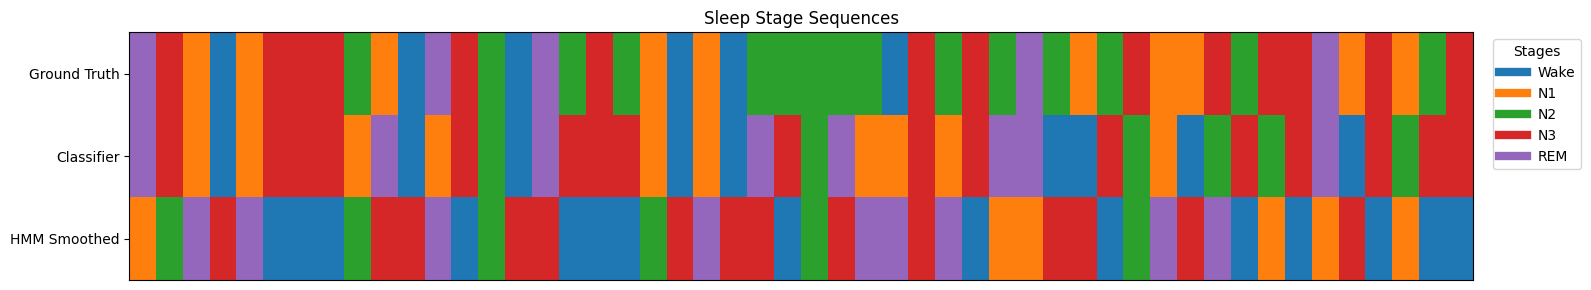

In [16]:
plot_sleep_sequences(
    y_true=y_test_decoded[:50],     # First ~50 minutes
    y_pred=y_pred_decoded[:50],
    y_hmm=smoothed_labels[:50],
    label_order=["Wake", "N1", "N2", "N3", "REM"]
)

### Data Augmentation, Not Rollback
Since smushing together ~100 eeg and hypnogram pairs (for the purpose of a large enough training sample), I've realized that this many different Cycles (complicated by Cycle 1 != Cycle 2) are present, and all mashed together as if it's 6000 hours of constant sleep.  
  
However, it makes sense why I had to do it. Now, in order to preserve the **temporal structure**, we're going to: 
1) Track sleep cycles explicitly
2) Add a `cycle_number` feature 
3) Test HMM-Smoothing on a per-night and per-cycle basis

If none of these options work, RNN or a Temportal CNN might be a better fit for the nature of our data.

In [43]:
# Sanity check for multiple REM instances

rem_count = 0

for i in range(len(y)): 
    if y[i] == 'REM' and y[i+1] == 'REM': 
        rem_count += 1

print(rem_count)

13
